# QBM Comparison Simulation vs. Annealer

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import k as k_B, h as h_P

k_B /= h_P * 1e9
matplotlib.rcParams.update({"font.size": 14})

from qbm.models import BQRBM
from qbm.utils import (
    Discretizer,
    kl_divergence,
    get_project_dir,
    get_rng,
    lr_exp_decay,
)

# configure directories
project_dir = get_project_dir()
example_dir = project_dir / "example"
models_dir = example_dir / "artifacts"
plots_dir = example_dir / "plots"
for dir_ in [example_dir, models_dir, plots_dir]:
    if not dir_.exists():
        dir_.mkdir(parents=True)

# load anneal schedule data
qpu_params = {"region": "na-west-1", "solver": "Advantage_system4.1"}
csv_name = "09-1263A-A_Advantage_system4_1_annealing_schedule.csv"
df_anneal = pd.read_csv(
    project_dir / f"data/anneal_schedules/csv/{csv_name}", index_col="s",
)
if 0.5 not in df_anneal.index:
    df_anneal.loc[0.5] = (df_anneal.loc[0.499] + df_anneal.loc[0.501]) / 2
df_anneal.sort_index(inplace=True)

time: 1.1 s (started: 2022-03-29 12:06:51 +02:00)


## Train Data Creation

In [2]:
seed = 42
n_visible = 8
n_hidden = 4
n_qubits = n_visible + n_hidden

rng = get_rng(seed)
n_samples = 1500
α = 2 / 3
N_1 = rng.normal(-2, 1, int(round(n_samples * α, 0)))
N_2 = rng.normal(3, 1, int(round(n_samples * (1 - α), 0)))
x = np.concatenate((N_1, N_2))

df = pd.DataFrame.from_dict({"x": x})
discretizer = Discretizer(df, n_bits=n_visible)
V_train = discretizer.df_to_bit_array(df)
V_train

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 1]])

time: 10.3 ms (started: 2022-03-29 12:06:52 +02:00)


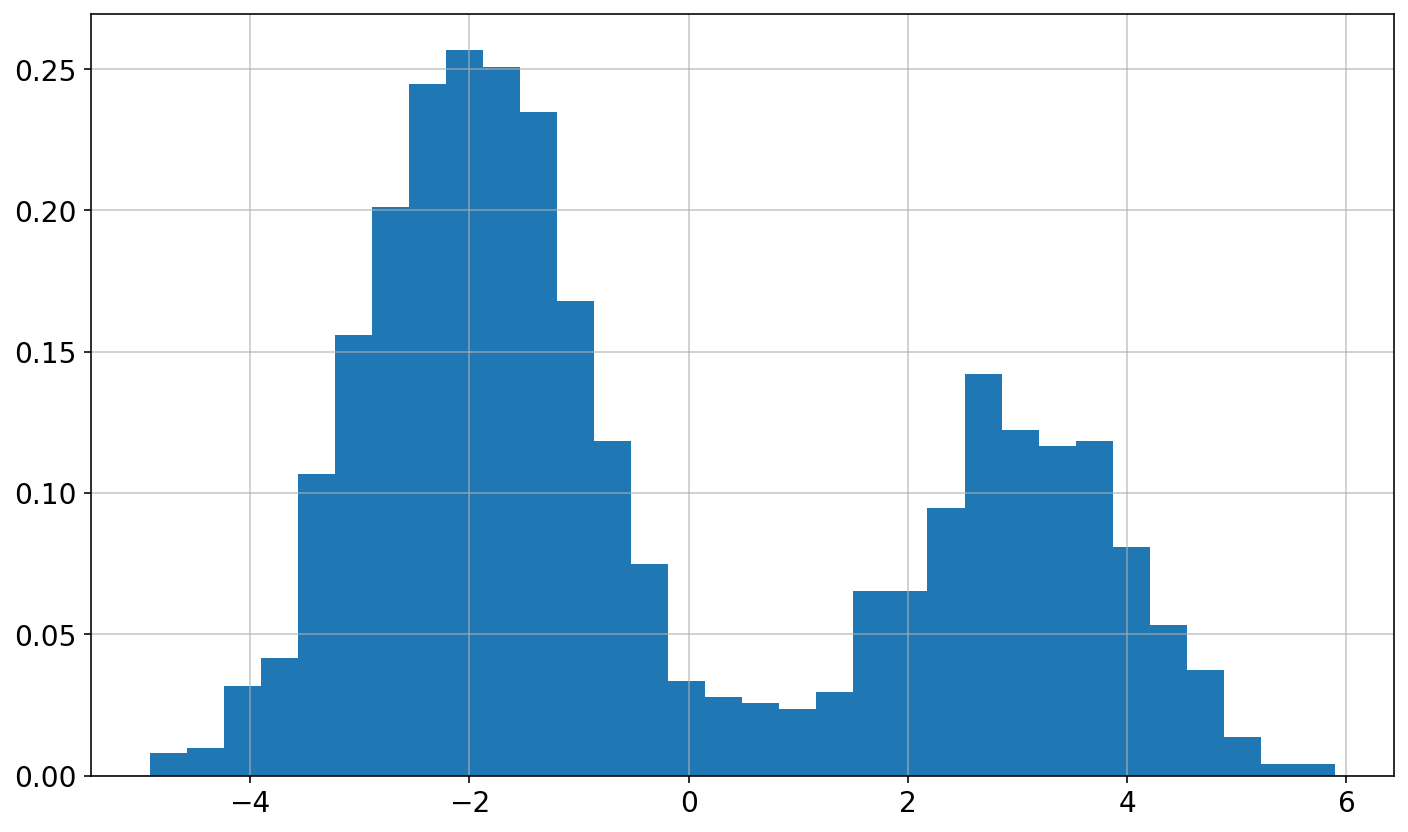

time: 231 ms (started: 2022-03-29 12:06:52 +02:00)


In [3]:
data = discretizer.undiscretize_df(discretizer.discretize_df(df))

n_bins = 32
fig, ax = plt.subplots(dpi=144, figsize=(10, 6))
_, bins, _ = ax.hist(data, bins=n_bins, density=True, label="Data")
ax.grid(alpha=0.7)
plt.tight_layout()
plt.savefig(plots_dir / "histogram_train.png")

In [4]:
def callback(model, sample_state_vectors):
    V_train = model.V_train
    n_visible = V_train.shape[1]
    train_states = (
        model._eigen_to_binary(V_train) * 2.0 ** np.arange(n_visible - 1, -1, -1)
    ).sum(axis=1)
    sample_states = (
        model._eigen_to_binary(sample_state_vectors[:, :n_visible])
        * 2.0 ** np.arange(n_visible - 1, -1, -1)
    ).sum(axis=1)

    dkl = kl_divergence(train_states, sample_states, n_bins=32)

    return {"value": dkl, "print": f"D_KL = {dkl:.3f}"}

time: 581 µs (started: 2022-03-29 12:06:53 +02:00)


## Simulation-based Model

In [5]:
train_model = True
model_path = models_dir / "model_simulation.pkl"
if train_model:
    # model params
    s_freeze = 1.0
    embedding = None
    beta_initial = 1
    simulation_params = {"beta": 0.5}

    # training params
    n_epochs = 100
    n_samples = 10_000
    learning_rate = 0.1
    mini_batch_size = 10
    decay_epoch = 50
    decay_period = 10
    epochs = np.arange(1, n_epochs + 1)
    learning_rates = learning_rate * lr_exp_decay(epochs, decay_epoch=50, period=10)
    learning_rates_beta = learning_rate * lr_exp_decay(
        epochs, decay_epoch=50, period=20
    )

    # model init
    model_simulation = BQRBM(
        V_train=V_train,
        n_hidden=n_hidden,
        A_freeze=df_anneal.loc[s_freeze, "A(s) (GHz)"],
        B_freeze=df_anneal.loc[s_freeze, "B(s) (GHz)"],
        beta_initial=beta_initial,
        simulation_params=simulation_params,
    )

    # model train and save
    model_simulation.train(
        n_epochs=n_epochs,
        n_samples=n_samples,
        learning_rate=learning_rates,
        learning_rate_beta=learning_rates_beta,
        mini_batch_size=mini_batch_size,
        callback=callback,
    )
    model_simulation.save(model_path)
else:
    model_simulation = BQRBM.load(model_path)

[BQRBM] epoch 1: β = 0.939, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.013722
D_KL = 0.269
[BQRBM] epoch 2: β = 0.848, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.057796
D_KL = 0.176
[BQRBM] epoch 3: β = 0.762, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.021872
D_KL = 0.103
[BQRBM] epoch 4: β = 0.709, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.018841
D_KL = 0.052
[BQRBM] epoch 5: β = 0.671, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.029039
D_KL = 0.056
[BQRBM] epoch 6: β = 0.644, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.022161
D_KL = 0.053
[BQRBM] epoch 7: β = 0.619, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.031665
D_KL = 0.046
[BQRBM] epoch 8: β = 0.602, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.0183

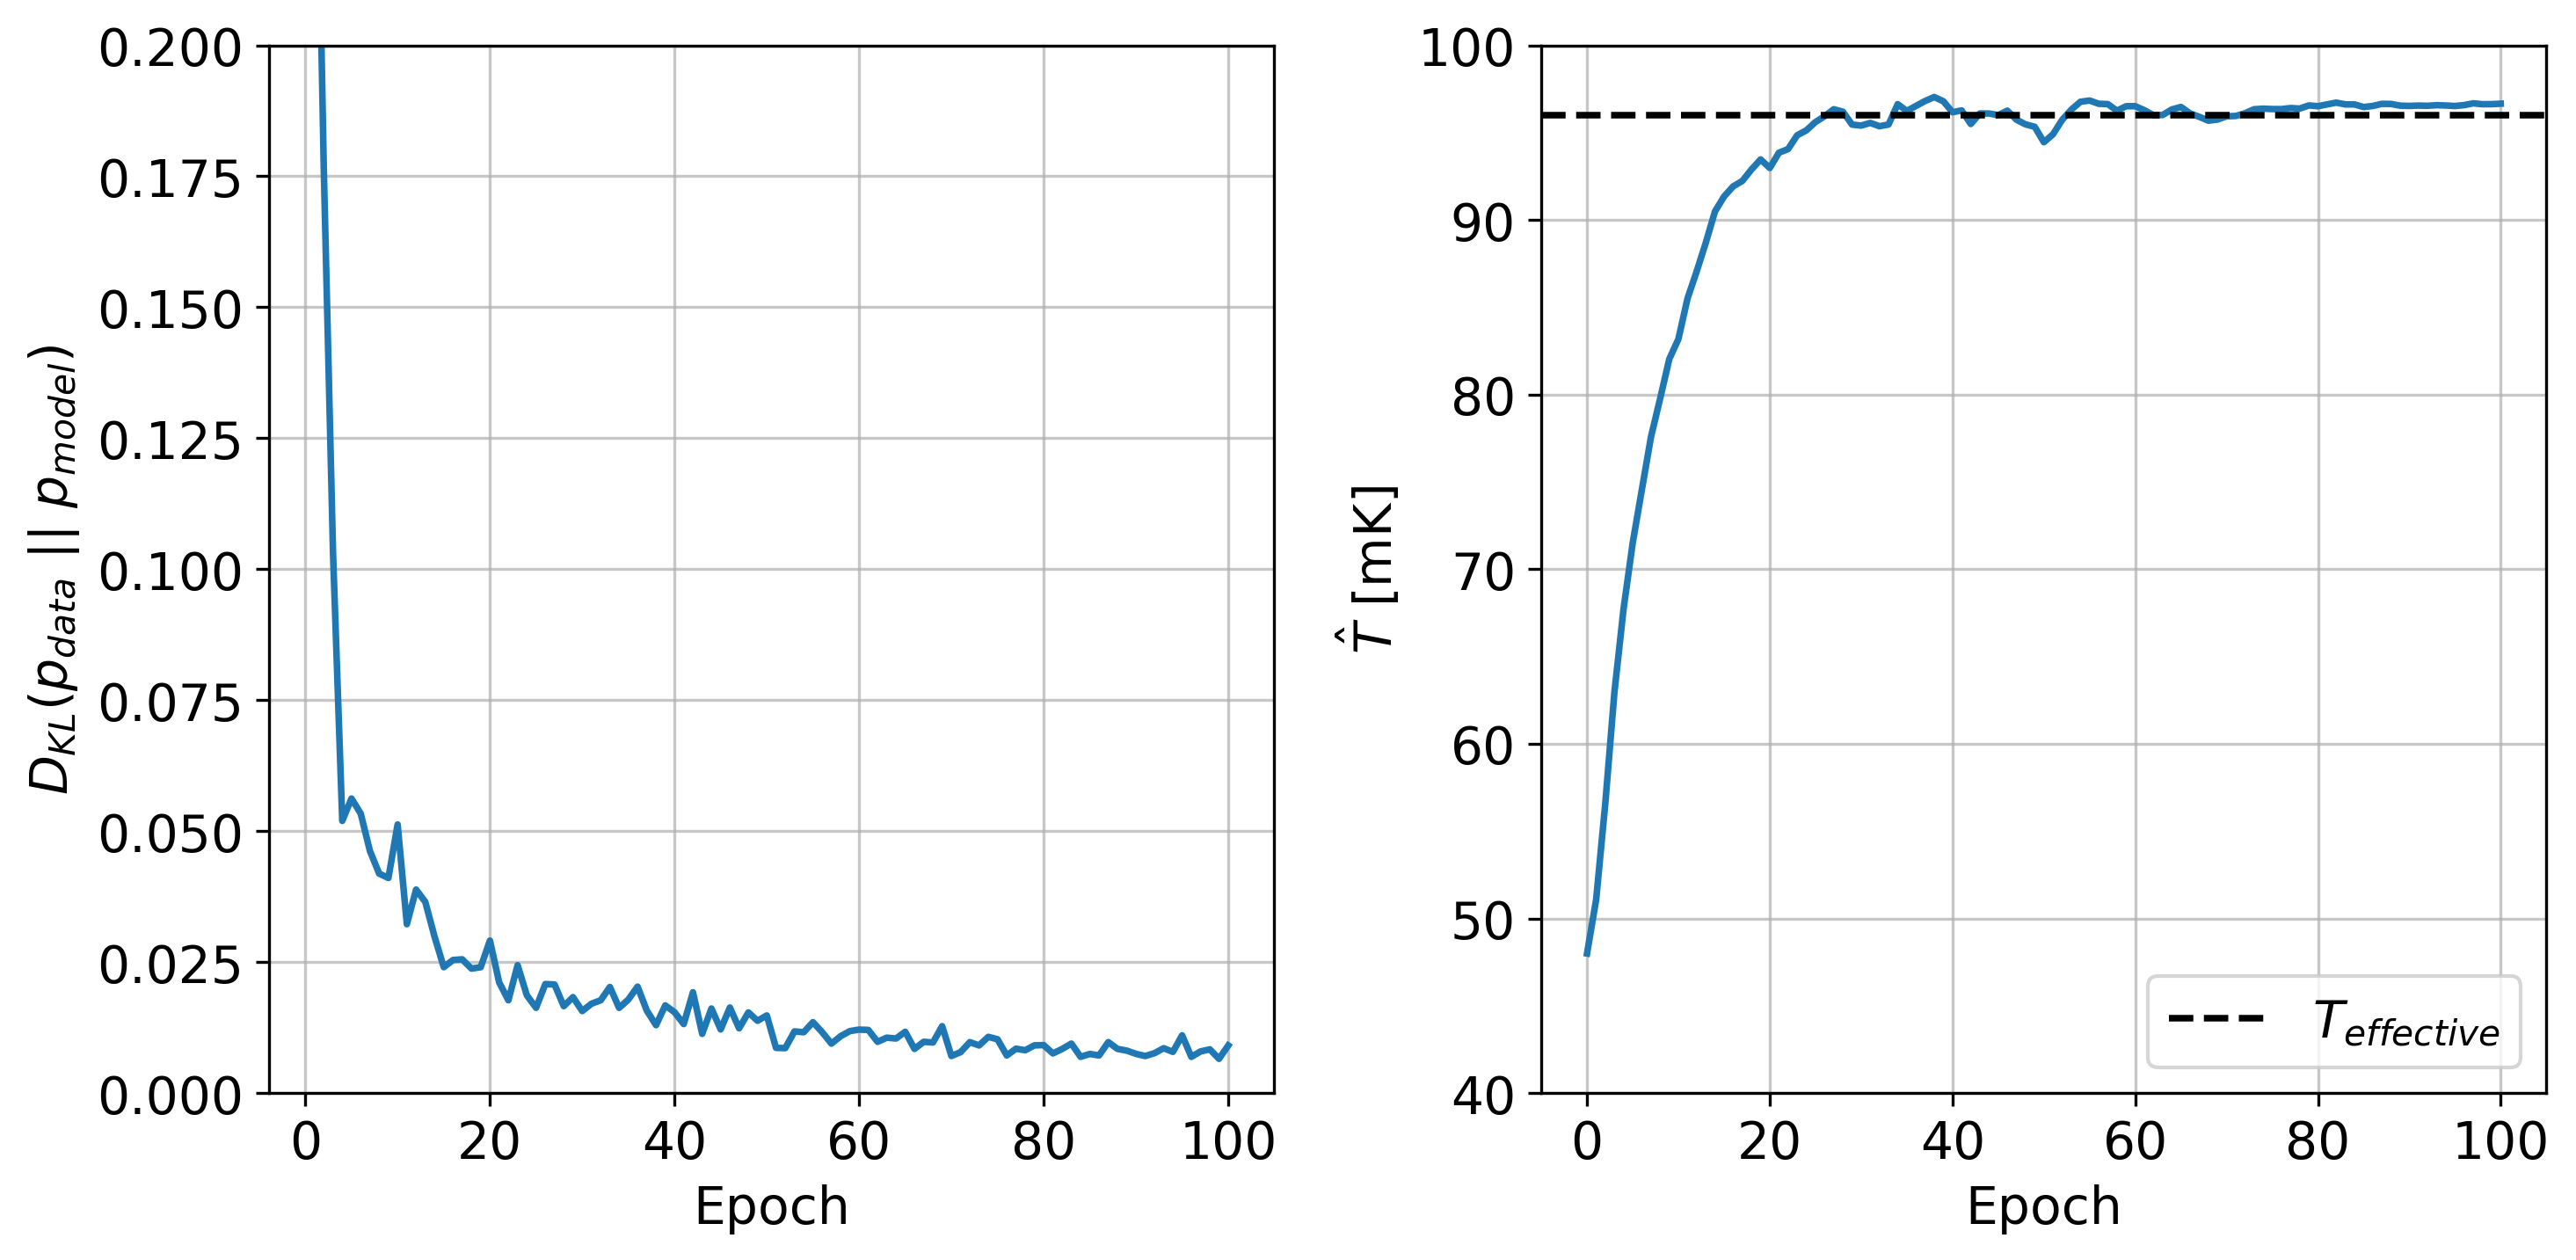

time: 785 ms (started: 2022-03-29 01:29:11 +02:00)


In [6]:
dkls = [x["value"] for x in model_simulation.callback_history]
epochs = np.arange(1, len(dkls) + 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax[0].plot(epochs, dkls, linewidth=1.8)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel(r"$D_{KL}(p_{data} \ || \ p_{model})$")
ax[0].set_yticks(np.arange(0, 22.5, 2.5) / 100)
ax[1].set_yticks(np.arange(40, 110, 10))
ax[0].set_ylim((0, 0.2))
ax[1].set_ylim((40, 100))
ax[0].grid(alpha=0.7)

ax[1].plot(
    range(len(model_simulation.beta_history)),
    1 / k_B / np.array(model_simulation.beta_history) * 1000,
    linewidth=1.8,
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
ax[1].axhline(
    1 / k_B / 0.5 * 1000,
    color="k",
    linestyle="--",
    label=r"$T_{effective}$",
    linewidth=1.8,
)
ax[1].grid(alpha=0.7)
ax[1].legend(loc="lower right")
plt.tight_layout()
plt.savefig(plots_dir / "train_results_simulation.png")

## Annealer-based Model

In [7]:
train_model = True
model_path = models_dir / "model_annealer.pkl"
if train_model:
    # model params
    s_freeze = 1.0
    beta_initial = 0.5

    # set embedding
    embedding = {
        0: [4909],
        1: [4939],
        2: [4879],
        3: [4774],
        4: [4789],
        5: [4924],
        6: [4864],
        7: [4894],
        8: [895],
        9: [850],
        10: [880],
        11: [865],
    }

    # set anneal schedule
    s_pause = 0.55
    t_r = 20
    α_quench = 2
    t_pause = round(s_pause * t_r, 3)
    Δ_quench = round((1 - s_pause) / α_quench, 3)
    if s_pause == 1:
        anneal_schedule = [(0, 0), (t_pause, s_pause)]
    else:
        anneal_schedule = [
            (0, 0),
            (t_pause, s_pause),
            (round(t_pause + Δ_quench, 3), 1),
        ]

    # training params
    n_epochs = 100
    n_samples = 10_000
    learning_rate = 0.1
    mini_batch_size = 10
    epochs = np.arange(1, n_epochs + 1)
    learning_rates = learning_rate * lr_exp_decay(epochs, decay_epoch=50, period=10)
    learning_rates_beta = learning_rate * lr_exp_decay(
        epochs, decay_epoch=50, period=20
    )

    # set the anneal params
    annealer_params = {
        "schedule": anneal_schedule,
        "embedding": embedding,
        "qpu_params": qpu_params,
    }

    # skip if model already exists
    if model_path.exists():
        raise Exception("Model already exists")

    # model init
    model_annealer = BQRBM(
        V_train=V_train,
        n_hidden=n_hidden,
        A_freeze=df_anneal.loc[s_freeze, "A(s) (GHz)"],
        B_freeze=df_anneal.loc[s_freeze, "B(s) (GHz)"],
        beta_initial=beta_initial,
        annealer_params=annealer_params,
    )

    # model train and save
    model_annealer.train(
        n_epochs=n_epochs,
        n_samples=n_samples,
        learning_rate=learning_rates,
        learning_rate_beta=learning_rates_beta,
        mini_batch_size=mini_batch_size,
        callback=callback,
    )
    model_annealer.save(model_path)
else:
    model_annealer = BQRBM.load(model_path)

[BQRBM] epoch 1: β = 0.484, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:07:08.907931
D_KL = 0.232
[BQRBM] epoch 2: β = 0.474, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:06:48.725121
D_KL = 0.106
[BQRBM] epoch 3: β = 0.486, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:04:01.671331
D_KL = 0.081
[BQRBM] epoch 4: β = 0.486, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:03:56.923078
D_KL = 0.109
[BQRBM] epoch 5: β = 0.483, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:03:38.070698
D_KL = 0.059
[BQRBM] epoch 6: β = 0.494, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:03:44.256469
D_KL = 0.062
[BQRBM] epoch 7: β = 0.485, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:03:01.542740
D_KL = 0.059
[BQRBM] epoch 8: β = 0.499, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:03:17.8571

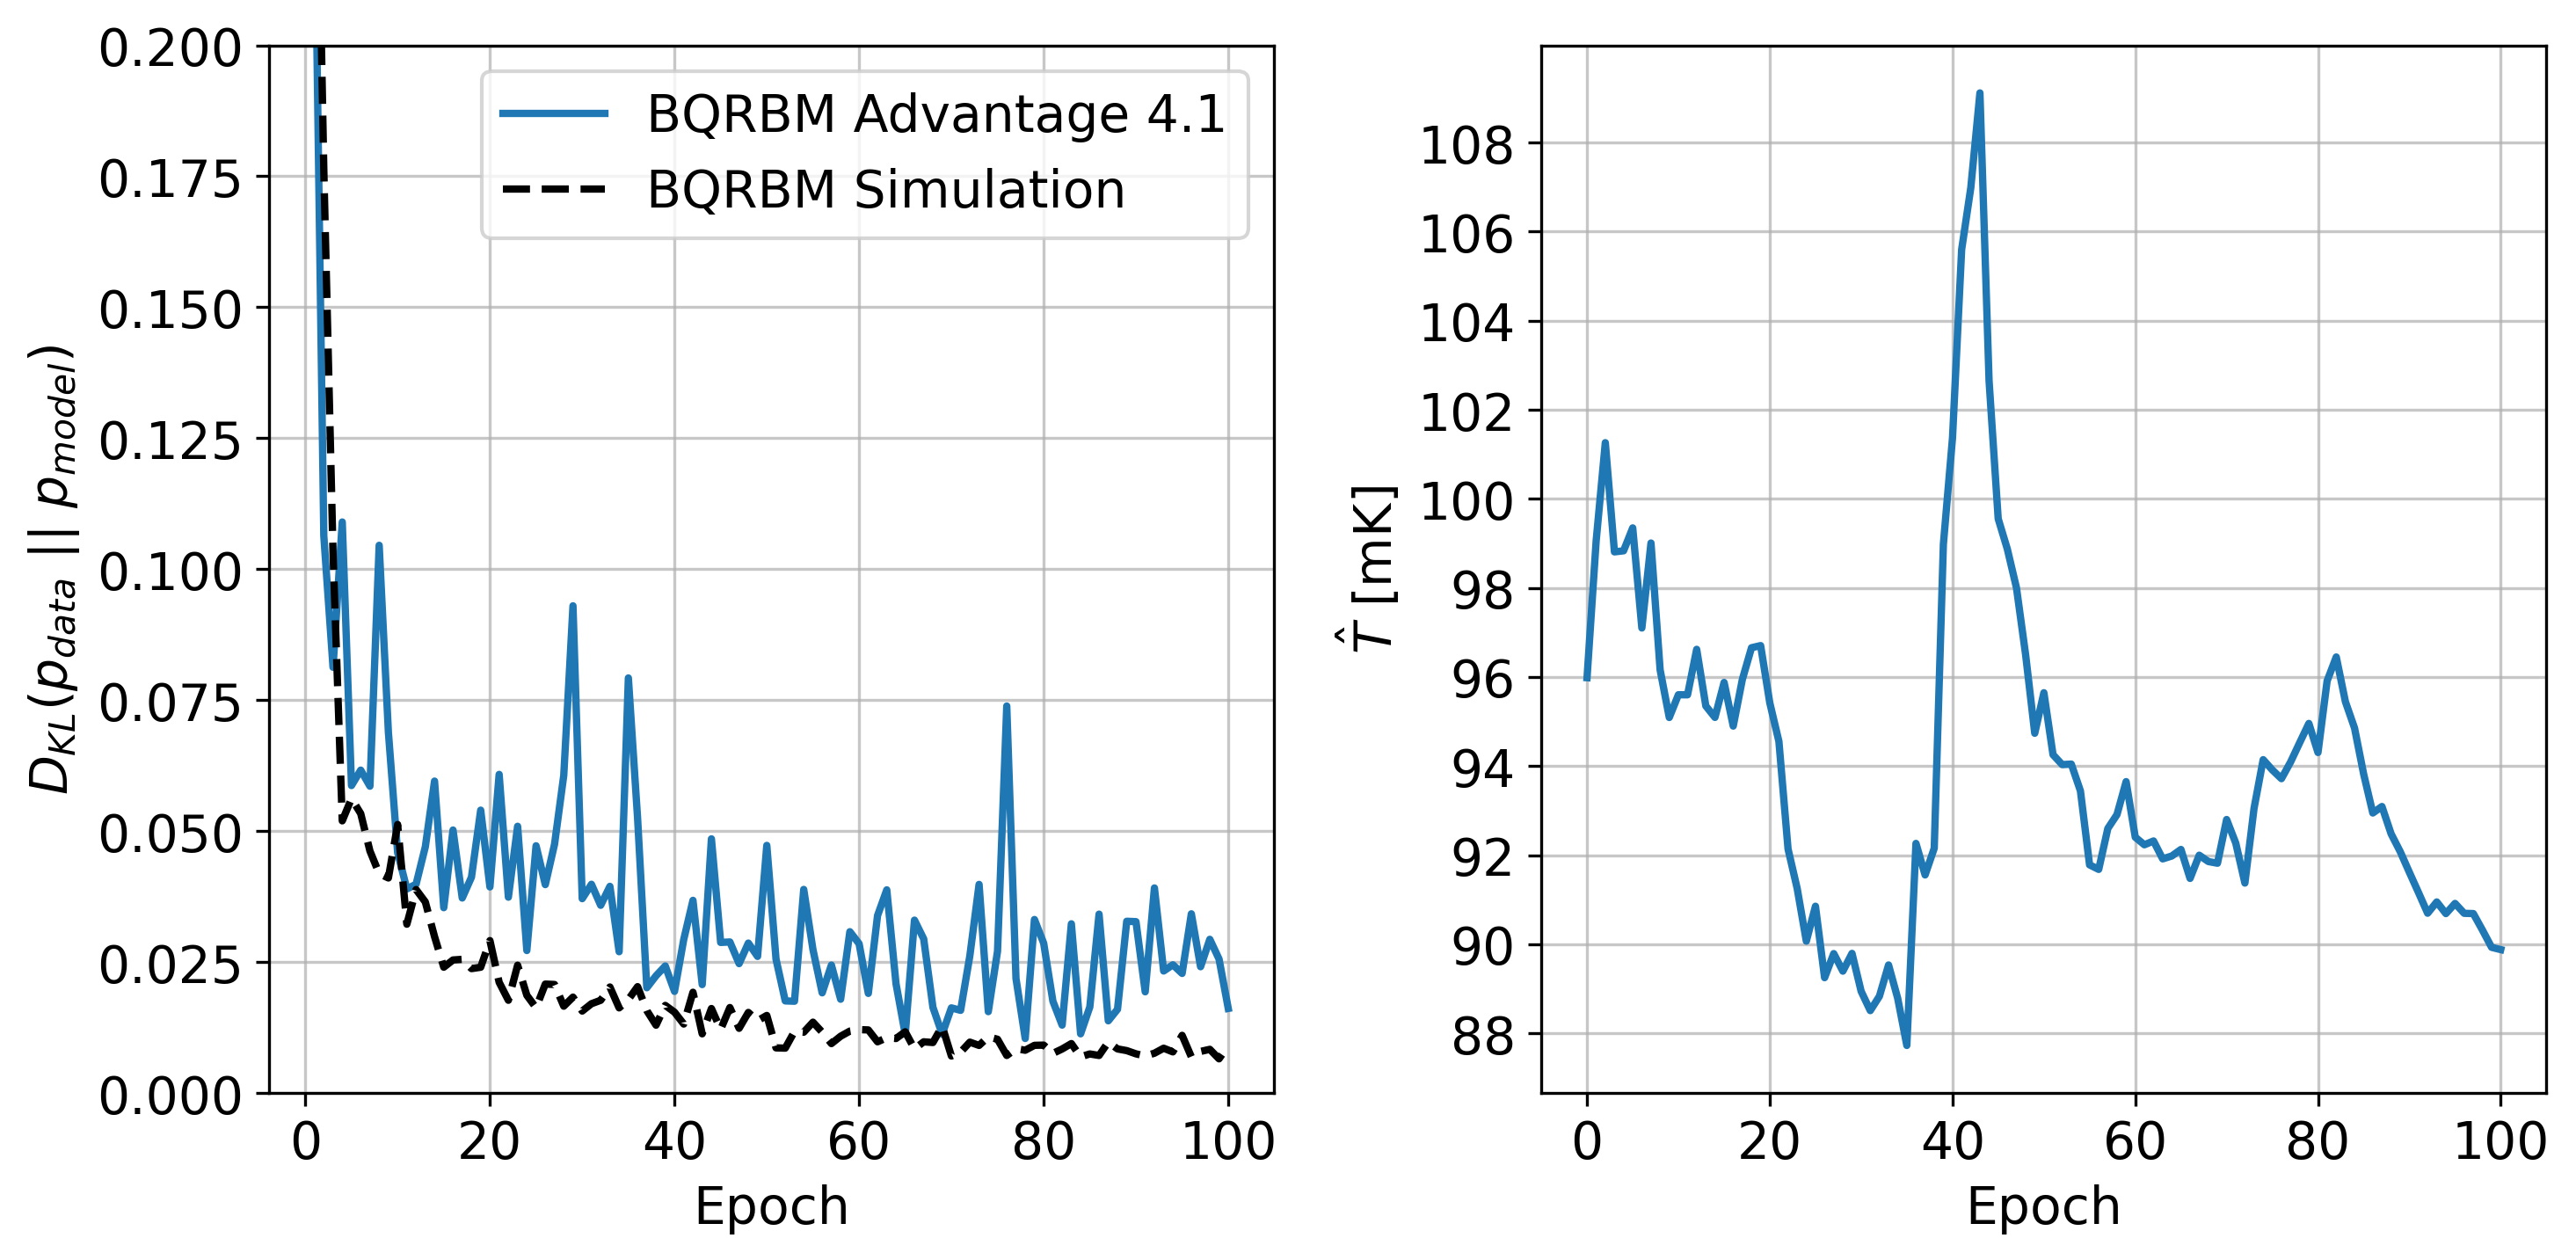

time: 873 ms (started: 2022-03-29 06:43:39 +02:00)


In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
dkls_simulation = [d["value"] for d in model_simulation.callback_history]
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel(r"$D_{KL}(p_{data} \ || \ p_{model})$")
ax[0].set_yticks(np.arange(0, 22.5, 2.5) / 100)
ax[1].set_yticks(np.arange(80, 110, 2))
ax[0].set_ylim((0, 0.2))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
dkls_annealer = [d["value"] for d in model_annealer.callback_history]

epochs = np.arange(1, len(dkls_simulation) + 1)
ax[0].plot(
    epochs,
    dkls_annealer,
    label=fr"BQRBM Advantage 4.1",
    color="tab:blue",
    linewidth=2,
)
ax[0].plot(
    epochs,
    dkls_simulation,
    label=r"BQRBM Simulation",
    color="k",
    linestyle="--",
    linewidth=2,
)

ax[1].plot(
    range(len(model_annealer.beta_history)),
    1 / k_B / np.array(model_annealer.beta_history) * 1000,
    color="tab:blue",
    linewidth=2,
)

ax[0].grid(alpha=0.7)
ax[1].grid(alpha=0.7)
ax[0].legend()
plt.tight_layout()
plt.savefig(plots_dir / "train_results_comparison.png")